# Overview

The Beginner Tutorial demonstrates how to create a maximum likelihood estimate (MLE) model from ordinal (i.e., ranked) similarity judgments. The tutorial mimics a simple pipeline that one could use in a research project. The tutorial aims to teach the basic organization and mechanics of PsiZ, giving readers the background necessary to use PsiZ in their own projects. The tutorial provides some introduction to TensorFlow, but familiarity with TensorFlow is assumed.

Big picture, PsiZ allows us to take some observable behavior (such as similarity judgments) and infer the likely psychological representations people use to perceive the world. PsiZ has been designed to be as flexible as possible and work with many different stimuli. While this tutorial focuses on a dataset of images, PsiZ can be used to model psychological representations of audio files, movies, words, odors and other stimuli. After completing this tutorial you should have a good idea how to redo the modeling using your own dataset.

The tutorial is divided into five parts:

1. Introduction
2. Data Preparation
3. Model Construction
4. Model Inference
5. Model Analysis

If you would like to run this notebook on your local machine, the file is available at [PsiZ's GitHub](https://github.com/roads/psiz/blob/main/docs/src/beginner_tutorial/beginner_tutorial.ipynb).


```{note}
The Beginner Tutorial introduces the simplest model for inferring embeddings. An MLE model is a point estimate model and on it's own does not provide information about model confidence (i.e., uncertainty). Readers interested in modeling uncertainty should explore the variational inference (VI) examples. For intelligent methods for selecting informative trials, please explore the active learning examples.
```

# Introduction

Imagine we are interested in understanding how the average person perceives a set of 208 bird images ({numref}`fig-birds-16-thumbs`). We would like to know how different species cluster in psychological space, which bird images are prototypical of their species, which species have the smallest/largest perceived variability, and what perceptual features are salient or ignored? Birds provide an interesting domain because with-in species variability can be as large as across-species variability.

```{figure} ../../img/birds-16_thumbs.png
---
align: center
name: fig-birds-16-thumbs
alt: "A 13-by-12 grid of thumbnail images."
---
All images in the birds-16 dataset. Each column depicts a single species.
```

While birds may not be interesting to everyone, being able to answer these questions means we can answer similar questions about other domains, such as understanding how medical professionals recognize which skin lesions are life threatening. A general approach to understanding human perception empowers scientist and policy makers to adopt strategies and interventions that help society. Once you know how something works, you can start to improve it. For example, medical training programs might be made more efficient and less effortful.

The fundamental premise of PsiZ is to use formal models to understand people's mental representations. Since people's mental representations are not directly observable, we use statistical inference to infer mental representations that are most likely to explain observable behavior ({numref}`fig-model-flow-1`). A PsiZ model has two primary components: a *psychological embedding* module and a *task* module. The psychological embedding module is unpacked in more detail later in the tutorial; for now it's sufficient to know this is where mental representations are modeled. The task module details how perceived similarity translates into observed behavior.

```{figure} ../../img/model_flow_1_v2.png
---
align: center
name: fig-model-flow-1
alt: "Trial and agent inputs feeding into large box denoting a cognitive model which outputs behavioral predictions. The large box has two smaller boxes denoting the two major modules: a psychological embedding and task module."
---
High-level organization of a generic PsiZ model. Trial and agent information is provided as input to a cognitive model. After internal processing, the model outputs the probability associated with different task behaviors. Trial information includes details about the *content* of the trial (e.g., information about the images shown on a trial). Agent information includes details about the human or computer agent (e.g., a personal identifier). The "wires" in the diagram show the flow of information through the model. Agent (yellow) and trial (blue) information can influence both the psychological embedding module and the task module. The psychological embedding module outputs information (purple) to the task module, which then outputs behavioral outcomes (red).
```

```{note}
Since PsiZ models can be run in generative mode, the models can be treated as *virtual subjects*. For this reason, we prefer the agnostic word *agent* rather than a more human-centric word.
```

The task module describes how mental representations are processed to yield observable behavior. Many tasks can be used to ellicit obserable behavior, but a handful of tasks are particularly popular for probing mental representations. Common tasks for elliciting observable behavior include:

* **pairwise rating**: given two images rate on a scale of 1 to 7 how similar the images are
* **triplet similarity**: given 1 image, select from the remaining two which is more similar
* **odd-one-out**: given three images, select the image that doesn't belong
* **categorization**: given an image, provide the category label.

Some tasks will be better suited for certain modalities. For example, if judging the similarity between odors, a researcher will need to present the odors separately whereas many images can be displayed at once. 

In this tutorial, we use a generalization of the triplet similarity task that includes triplet trials as a special case. In addition to showing three images on each trial, some trials involve a grid composed of nine images ({numref}`fig-bird-trial-display`). The center image is called the *query* and the surrounding images are called *references*. Instead of selecting just one reference image, the task is to select the two reference images that are most similar to the query. In addition, participants rank their choices. Completing one of these displays constitutes one *ranked 8-choose-2 similarity judgment*. From this perspective, a traditional triplet trial could be called a *2-choose-1 similarity judgment*.

```{figure} ../../img/bird_trial_display.gif
---
align: center
name: fig-bird-trial-display
alt: Animated GIF showing how participants select reference images given a query image.
---
Recording of B.R. completing two ranked 8-choose-2 similarity trials.
```

The advantage of these many-image trials is that additional information can be collected without requiring much additional time from the participant, reducing labor costs. Loosely speaking, a ranked 8-choose-2 trial contains a similar amount of information as 13 traditional 2-choose-1 trials. To see why, consider a 2-choose-1 trial with query stimulus $q$ and reference stimuli $a$ and $b$. If a participant selects $a$ as more similar, we can use a shorthand to denote the outcome of this trial $q: a > b$. In an 8-choose-2 scenario, there are eight references ($a$-$h$). If a participant selects $a$ as the most similar and $b$ as the second most similar, this implies the following 13 triplet relations:

```{eval-rst}
.. hlist::
   :columns: 5

   * :math:`q: a > b`
   * :math:`q: a > c`
   * :math:`q: a > d`
   * :math:`q: a > e`
   * :math:`q: a > f`
   * :math:`q: a > g`
   * :math:`q: a > h`
   * :math:`q: b > c`
   * :math:`q: b > d`
   * :math:`q: b > e`
   * :math:`q: b > f`
   * :math:`q: b > g`
   * :math:`q: b > h`
```

If we collect enough trials, we can use all the implied triplet contraints to infer a multidimensional representation of how people perceive the stimuli ({numref}`fig-bird-embedding-3d`). Stimuli that are judged as similar are placed close together in psychological space and stimuli judged as dissimilar are placed far apart. We refer to this kind of representation as a *psychological embedding*. If you give the same trial to different people, you may get different responses (i.e., between-subject variability). The same person might even give different reponses for the same trial at different points in time (i.e., within-subject variability). The inference procedure will find the embedding that best satisfies all the (potentially noisy) trials.

```{figure} ../../img/birds-16_emb_3d.gif
---
align: center
name: fig-bird-embedding-3d
alt: Animated GIF showing a 3D embedding of how people perceive images of birds. The embedding shows that people tend to percieve birds of the same species and family as more similar that images of birds from different species and families.
---
A 3D psychological embedding of bird images derived from human responses. Each dot represents one image and is color-coded based on species membership. The plot shows how bird images of the same species tend to cluster close together. On a larger scale, bird images belonging to the same taxonomic family also tend to cluster together.
```

```{note}
It is difficult to predict how many trials will be necessary to obtain a high-quality embedding. There are three main factors that influence this number. First, more stimuli necessitates more trials. Second, low within- and between-subject agreement will necessitate more trials. Third, the collection strategy impacts how many trials are necessary. For example, using active learning instead of random trials can greatly reduce the number of trials necessary. While predicting the necessary number of trials is challenging, post hoc evaluation is relatively straightforward. After some trials have been collected, one can use a version of Representational Similarity Analysis (RSA) to determine if a sufficient number of trials have been collected. RSA is discussed more towards the end of this tutorial.
```

# Data Preparation

## Basic Setup

Start by importing the major packages we need: `tensorflow` and `psiz`. We also import `os` to adjust environment variables. TensorFlow's (TF) noisy default output is dialed down to a quieter setting that only outputs error messages (warnings and informational messages are silenced).

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

import psiz

# Optional settings, see Note for explanation.
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # A
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # A
# tf.config.run_functions_eagerly(True)  # B

```{note}
If you want to force execution to use a specific GPU, you can uncomment the lines marked with an `A`. If uncommented, the current setting will force execution to use "GPU 0". If you want to force *eager execution*, uncomment the line marked with a `B`. Eager execution is useful for debugging since it uses a non-optimized CPU mode that allows step-by-step inspection of variable values. See the [TensorFlow Guide](https://www.tensorflow.org/guide/effective_tf2#debugging) for more information.
```

## Load the Dataset

For this tutorial, we will use a previously collected set of ranked similarity judgments {cite}`Roads_Mozer_2019_BRM`. The judgments were collected while participants viewed sets of bird images. The bird images are derived from the CUB200 bird dataset {cite}`Wah_etal_CUB200_2011`. When we import the data using the `psiz.datasets` module, we also import a catalog that maps embedding indices to stimulus information (e.g., filenames and class labels). The first time you load the bird-16 dataset, it will be automatically downloaded from the OSF repository.

In [2]:
# Load hosted dataset.
(obs, catalog) = psiz.datasets.load_dataset('birds-16', verbose=1)

# Inspect object types.
print("'obs' type: {0}".format(type(obs)))
print("'catalog' type: {0}".format(type(catalog)))


24576/23883 [==============================] - 0s 0us/step
Dataset Summary
  n_stimuli: 208
  n_trial: 16292
'obs' type: <class 'psiz.trials.similarity.rank.rank_observations.RankObservations'>
'catalog' type: <class 'psiz.catalog.catalog.Catalog'>


### Catalog Object

Taking a look at the `catalog` object, we inspect the `stimuli` attribute to view information about each stimulus. The `stimuli` attribute is a Pandas `DataFrame` object. Most importantly, we can see the `id` (i.e., embedding index) assigned to each image.

In [3]:
catalog.stimuli.head()

,id,filepath,class_id
0,1,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
1,2,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
2,3,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
3,4,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
4,5,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2


```{warning}
You may have noticed that the `id`s begin at `1`, not `0`. This is intentional and will be explained shortly.
```

### Rank Observation Object

Next, we can take a look inside the `obs` object. If you recall, earlier it was mentioned that we will be using a dataset composed of two *trial configurations*: 2-choose-1 and 8-choose-2 trials. You can inspect the different trial configurations contained in the `obs` object via the `config_list` attribute. This attribute tracks all the different ranked similarity configurations contained in the object. The object also tracks agent information (`groups_0`, useful for partitioning data) and the number of unique outcomes associated with a particular trial configuration (`n_outcome`).

In [4]:
print(obs.config_list)

      n_reference  n_select  is_ranked  groups_0  n_outcome
0               8         2       True         0         56
1416            2         1       True         0          2


The output confirms that the dataset contains 8-choose-2 trials and 2-choose-1 trials. Let's dive deeper and inspect three trials of each configuration.

In [5]:
# Inspect three 8-choose-2 trials.
print('8-choose-2 Examples')
trial_idxs = [0, 1, 2]
print('Stimuli indices for each trial:')
print(obs.stimulus_set[trial_idxs])
print('Number of selected references for each trial:')
print(obs.n_select[trial_idxs])
print()

# Inspect three 2-choose-1 trials.
print('2-choose-1 Examples')
trial_idxs = [1416, 1417, 1418]
print('Stimuli indices for each trial:')
print(obs.stimulus_set[trial_idxs])
print('Number of selected references for each trial:')
print(obs.n_select[trial_idxs])

8-choose-2 Examples
Stimuli indices for each trial:
[[122 105 141  63 189  90 201 148  94]
 [175 182 179 170 171 173 176 178 181]
 [ 63  61 200 165 195 118 141 197 156]]
Number of selected references for each trial:
[2 2 2]

2-choose-1 Examples
Stimuli indices for each trial:
[[156 148 192   0   0   0   0   0   0]
 [142 140 169   0   0   0   0   0   0]
 [134 132  79   0   0   0   0   0   0]]
Number of selected references for each trial:
[1 1 1]


There a few points worth elaborating:
1. Instead of storing stimuli filenames in the `obs` object, we store stimuli `id`s, which are treated as embedding indices (more on this later). Since each trial is composed of a set of stimuli, we name this attribute `stimulus_set`.
2. In a `RankObservations` class, the stimuli indices for each trial are stored following a convention ({numref}`fig_8-choose-2_label_convention`). The convention is best explained using abstract notation. In the 8-choose-2 case, we use the following notation: query stimulus ($q$), first chosen reference ($a$), second chosen reference ($b$), and all remaining unchosen references ($c$-$h$). The convention stipulates that the $i$th observed trial is recorded using the array format $\mathcal{D}_{i}=\left[q, a, b, c, d, e, f, g, h\right]$. All trials are then stacked to create a complete set of observed data $\mathcal{D}$. The convention is similar for 2-choose-1 trials; $\mathcal{D}_{i}=\left[q, a, b\right]$, where $a$ is the selected reference and $b$ is the unselected reference. In the 2-choose-1 case, a *mask value* of `0` is used to pad out the "unused" references.
3. The `obs` object also includes an `n_select` attribute that tracks how many references partipants had to choose for the trial.

```{figure} ../../img/n-choose-k_label_convention.png
---
align: center
name: fig_8-choose-2_label_convention
alt: Diagram showing labeling convention of stimuli.
---
Example demonstrating how a single 2-choose-1 and 8-choose-2 similarity trial are recorded. Instead of showing actual images, abstract boxes are used to denote a stimuli. The color of the box indicates wether a stimulus is a query (yellow), selected reference (blue), or unselected reference (gray). 
```

```{warning}
After printing out the stimuli indices for the 2-choose-1 trials, you can see why the stimuli indices started at `1`. The index `0` is used as a special placeholder or *mask value*. The mask value allows us to neatly stack trials that are composed of a different number of stimuli (i.e., nine versus three stimuli). When we build our model, we will make sure to let the model know that `0` should be interpretted as a mask by passing `mask_zero=True` as an argument. In general, you can use data and build models that do not use masking; but many situations---such as using multiple trial configurations---require masking. For more on this design choice, you can read [The *mask_zero* Convention](../design/mask_zero.rst).
```

## Partition the Dataset

In general, when fitting a model we are primarily intersted in how well a model generalizes to **new** data and therefore want to prevent overfitting. To achive this goal we follow standard practice and partition the data into a train, validation, and test set. In this tutorial we use an 80:10:10 split.

```{note}
If you take a look at [the code](https://github.com/roads/psiz/blob/main/src/psiz/utils/standard_split.py) for the `psiz.utils.standard_split` function, you will see that care is taken to balance the number of different trial configurations across each split. This ensures that a given split is not dominated by 2-choose-1 or 8-choose-2 trials, but reflects the overall configuration proportion of the dataset.
```

In [6]:
# Partition observations.
obs_train, obs_val, obs_test = psiz.utils.standard_split(obs)
print(
    '\nData Split\n  obs_train:'
    ' {0}\n  obs_val: {1}\n  obs_test: {2}'.format(
        obs_train.n_trial, obs_val.n_trial, obs_test.n_trial
    )
)


Data Split
  obs_train: 13033
  obs_val: 1629
  obs_test: 1630


Since we are using the TensorFlow (TF) ecosystem, we convert the data objects into `tf.data.Dataset` objects. This allows us to seamlessly exploit TF's powerful inference pipeline. The `shuffle` method tells TF how we want to split the data into batches that will be used to update the model parameters. You can learn more by going to [TF's tf.data.Dataset documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

```{note}
The `batch_size` is typically chosen to be a power of 2 since this tends to be more efficient for reasons related to computer architecture. In memory-intensive applications, one typically picks the largest possible power of 2 such that the memory footprint of the batch will still fit on the GPUs/TPUs being used. However, you do not want a batch size that is so large that there is only one batch because multiple batches adds noise that helps gradient decent avoid local optimums (an important theoretical properity of stochastic gradient decent). In this application, our memory-footprint is small and a wide range of values work well.
```

In [7]:
# Set the batch_size.
batch_size = 128

# Convert observations to TF dataset.
ds_obs_train = obs_train.as_dataset().shuffle(
    buffer_size=obs_train.n_trial, seed=252, reshuffle_each_iteration=True
).batch(batch_size, drop_remainder=False)
ds_obs_val = obs_val.as_dataset().batch(
    batch_size, drop_remainder=False
)
ds_obs_test = obs_test.as_dataset().batch(
    batch_size, drop_remainder=False
)

With our data ready, we can move on to constructing our model.

# Model Construction

As described previously, a PsiZ model contains two types of modules. The first module type is a *psychological embedding* which models how individuals perceive the world. The second module type is a *task* module. The task module describes how stimulus perception yields the observed task behaviour. These components are intentionally denoted as *modules* because they can be swapped out for more complicated embeddings or to predict different tasks.

In this tutorial, we use a model that exhibits a few convenient simplifications ({numref}`fig-model_2c1_example`). First, we will use a *population-level* model where the free parameters are fit to all of the data and ignore agent information (i.e., individual differences). For this reason, the yellow agent wiring has been omitted from the figure. Second, since all of our observations are ranked similarity judgments, we only need one task module. Lastly, we will use the the simplest embedding module, a maximum likelihood estimate or MLE embedding.
 
```{figure} ../../img/model_2c1_example_v2.png
---
align: center
name: fig-model_2c1_example
alt: "A flow diagram showing inputs feeding to an embedding module, then a ranked similarity task module, and then producing behavioral outputs."
---
A diagram of the model used in this tutorial. The diagram is simplified by assuming there are only 10 stimuli even though the actual dataset contains 208 stimuli. The diagram is further simplified by showing the flow of information for a 2-choose-1 trial.
```

To avoid cluttering the tutorial with code snippets, let's start by defining the complete function that creates our model. This way the relevant model code is all in one place. Then we can unpack the model code in more detail.

```{note}
It is good practice to encapsulate your model construction code in a separate function. Such a function makes it easy to create multiple model instances. Writing the function with an `n_dim` argument is useful for scripts that use cross-validation to determine the optimal dimensionality. An optional `seed` argument is useful for managing reproducibility.
```

```{note}
In TensorFlow, a *layer* is the name used for an abstract building block of a model. When using TensorFlow it is best practice to assemble your models from layers. One of the main benefits of PsiZ is the set of layers it provides.
```

In [8]:
def build_model(n_stimuli, n_dim, seed=None):
    """Build population-level, MLE, rank similarity model.

    Arguments:
        n_stimuli: Integer indicating the number of stimuli in the
            embedding.
        n_dim: Integer indicating the dimensionality of the embedding.
        seed (optional): Integer that controls initialization of
            embedding layer.

    Returns:
        model: A TensorFlow Keras model.

    """
    # Create an `Embedding` layer that contains free parameters representing
    # the psychological coordinates of the stimuli.
    stimuli = tf.keras.layers.Embedding(
        n_stimuli + 1, n_dim, mask_zero=True,
        embeddings_initializer=tf.keras.initializers.RandomUniform(seed=seed)
    )

    # Create a similarity kernel layer that computes the similarity between
    # coordinates in psychological space.
    kernel = psiz.keras.layers.DistanceBased(
        distance=psiz.keras.layers.Minkowski(
            rho_initializer=tf.keras.initializers.Constant(2.),
            w_initializer=tf.keras.initializers.Constant(1.),
            trainable=False
        ),
        similarity=psiz.keras.layers.ExponentialSimilarity(
            beta_initializer=tf.keras.initializers.Constant(10.),
            tau_initializer=tf.keras.initializers.Constant(1.),
            gamma_initializer=tf.keras.initializers.Constant(0.),
            trainable=False,
        )
    )

    # Pass component layers to a `Rank` model.
    model = psiz.keras.models.Rank(stimuli=stimuli, kernel=kernel)
    return model

## Psychological Embedding Module

Let's unpack the psychological embedding code. A psychological embedding module includes two conceptual parts: a conventional embedding layer (representing the stimuli coordinates in psychological space) and a kernel layer (i.e., similarity function) that defines how similarity is computed between the embedding coordinates.

The coordinates are assigned to the layer variable `stimuli`. If we assume that the embedding has `N` stiumi and `D` dimensions, then the `stimuli` layer has a learnable weight matrix $\bm{Z} \in \mathbb{R}^{N \times D}$. The weight matrix $\bm{Z}$ behaves somewhat like a lookup table during a forward pass of the model. For example, consider the case where a 2-choose-1 trial is presented to the model (the case shown in {numref}`fig-model_2c1_example`). If stimulus `9` is the query and stimuli `1` and `7` are references (i.e., $\bm{x}_i = \left[9, 1, 7 \right]$), we would grab the corresponding rows of $\bm{Z}$: $\bm{z}_9$, $\bm{z}_1$, and $\bm{z}_7$. Each of these rows, or vectors, represents the corresponding $d$-dimensional coordinates of stimuli `9`, `1`, and `7`. By default, the weight matrix $\bm{Z}$ is randomly initialized according to a uniform distribution. In our construction code, the initialization is made explicit so that we can pass it a `seed` value, which allows us to control the reproducability of the initialization. We use the `mask_zero` argument to let the model know it should ignore `0` placeholder integers.

The similarity kernel is assigned to the layer variable `kernel`. The kernel layer is itself composed of two layers: a `psiz.keras.layers.Minkowski` layer and a `psiz.keras.layers.ExponentialSimilarity` layer. It is worth noting up front that these two layers are parameterized and the parameters can be learned from the data. To keep the tutorial simple, all of the kernel parameters are set to sensible values and made untrainable via the `trainable=False` argument. The `Minkowski` layer computes the weighted Minkowski distance between two vectors:
```{math}
:label: eq:minkowski
\mathrm{d} \left( \bm{z}_i, \bm{z}_j \right) = \| \bm{z}_i - \bm{z}_j\|_{\rho, \bm{w}} = \left[ \sum^{D}_{d} w_{d} \left( z_{i,d} - z_{j,d}\right)^{\rho} \right]^{\frac{1}{\rho}}.
```
The distance function parameters are set to $\rho=2$ and $\bm{w}=\bm{1}$, which yields the standard Euclidean distance function. The `ExponentialSimilarity` layer takes the distance and applies a non-linear mapping:
```{math}
:label: eq:similarity
\mathrm{s} \left( \bm{z}_i, \bm{z}_j \right) = \mathrm{exp}\left(-\beta \mathrm{d}\left( \bm{z}_i, \bm{z}_j \right)^{\tau} \right) + \gamma.
```
The similarity function parameters are set to $\beta=10$, $\gamma=0$, and $\tau=1$; yielding similarity that decays exponentially as distance increases.

The psychological theory motivating this kernel can be found elsewhere {cite}`Jones_Love_Maddox_2006,Jones_Maddox_Love_2006,Nosofsky_1986,Roads_Mozer_2019_BRM,Shepard_1987`, but it is worth noting that many other kernels are possible. Decomposing the kernel into two layers makes it easy to explore many different types of similarity kernels. For example, one might want to try a heavy-tailed similarity function that is popular in the machine learning literature {cite}`vanderMaaten_2012:MLSP` or even substitute a non-Minkowski distance function.

Continuing with our 2-choose-1 example, the coordinates ($\bm{z}_9$, $\bm{z}_1$, $\bm{z}_9$) are used in the kernel to compute similarity. A 2-choose-1 trial involves computing two similarities: $\mathrm{s}\left( \bm{z}_9, \bm{z}_1 \right)$ and $\mathrm{s}\left( \bm{z}_9, \bm{z}_1 \right)$. The computed similarity values are then passed to the task module.

## Task Module

The task module converts the perceived similarity into a behavioral outcome. In the case of a 2-choose-1 trial, a reference is selected in proportion to its similarity with the query. The probability of selecting reference `a` instead of reference `b` is: 
```{math}
:label: eq:2-choose-1
\mathrm{P} \left( \mathcal{D}_{i} = \left[q, a, b \right] \right) = \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right)}{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right) + \mathrm{s} \left( \bm{z}_q, \bm{z}_b \right)}.
```
Continuing with our concrete example, the probabilty of selecting reference `1` is:
```{math}
:label: eq:2-choose-1-a
\mathrm{P} \left( \mathcal{D}_{i} = \left[9, 1, 7 \right] \right) = \frac{\mathrm{s} \left( \bm{z}_9, \bm{z}_1 \right)}{\mathrm{s} \left( \bm{z}_9, \bm{z}_1 \right) + \mathrm{s} \left( \bm{z}_9, \bm{z}_7 \right)}.
```

The 8-choose-2 case is slightly more complicated since there are more references and there are two sequential choices. More references are easily handled by switching to summation notation and multiple choices are handled by recognizing a sequence of choices is expressed as a product of the individual choices: 
```{math}
:label: eq:8-choose-2-b
\mathrm{P} \left( \mathcal{D}_{i} = \left[q, a, b, c, d, e, f, g, h \right] \right) = \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right)}{\sum_{i \in 
 \{a-h\}} \mathrm{s} \left( \bm{z}_q, \bm{z}_i \right)} \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_b \right)}{ \sum_{j \in \{b-h\}} \mathrm{s} \left( \bm{z}_q, \bm{z}_j \right)}.
```

Using these equations you can compute the probabilities associated with all possible outcomes. For a 2-choose-1 trial there are two possible outcomes. for a 8-choose-2 trial there are 56 possible outcomes. If one needs to run a model in generative mode, these probabilties can be converted to a single outcome by sampling from the probabilies (i.e., sampling from the corresponding categorical distribution).

# Model Inference

For this tutorial we will infer a two-dimensional embedding since our primary goal is to obtain a convenient visualization. When inferring an embedding that is meant to serve as more than a visualization, it is important to select the dimensionality in a principled manner (e.g., via cross-validation).

We will create two models with identical architectures but different weight initializations in order to address three questions:
1. How do different initializations impact the inferred solutions?
2. How do we compare different solutions?
2. How do we know when sufficient data has been collected?

In [9]:
# Set the number of dimensions for the embedding.
n_dim = 2

# Instantiate two models using two different seeds.
model_0 = build_model(catalog.n_stimuli, n_dim, seed=0)
model_1 = build_model(catalog.n_stimuli, n_dim, seed=3)

We will train our models until validation loss stops improving. This is implemented using an `EarlyStopping` callback. Since PsiZ carefully adheres to TF idioms, we can easily use TF features like Callbacks without any headaches. See TF documentation for more on [TF Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback). The number of epochs (`epochs`) is set to a sufficiently high number that the model reaches the early stopping criteria before the maximum number of epochs is exceeded. For our loss, we use categorical crossentropy because we are computing the probability of all possible outcomes (a categorical output).

```{note}
It is often wise to ecapsulate your training routine in a separate function.
```

```{note}
Inference can take a few minutes to run depending on the hardware you are using.
```

In [18]:
def train_routine(model, ds_obs_train, ds_obs_val, ds_obs_test):
    """Run training routine.
    
    Arguments:
        model: A PsiZ model.
        ds_obs_train: A TF Dataset object of train data.
        ds_obs_val: A TF Dataset object of validation data.
        ds_obs_test: A TF Dataset object of test data.

    Returns:
        metrics: A dictionary of metrics.

    """
    epochs = 1000

    compile_kwargs = {
        'loss': tf.keras.losses.CategoricalCrossentropy(),
        'optimizer': tf.keras.optimizers.Adam(learning_rate=.001),
    }

    # Define an early stopping callback.
    early_stop = tf.keras.callbacks.EarlyStopping(
        'val_loss', patience=30, mode='min', restore_best_weights=True
    )
    callbacks = [early_stop]

    model.compile(**compile_kwargs)
    history = model.fit(
        x=ds_obs_train, validation_data=ds_obs_val, epochs=epochs,
        callbacks=callbacks, verbose=0
    )
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    test_metrics = model.evaluate(
        ds_obs_test, verbose=0, return_dict=True
    )
    test_loss = test_metrics['loss']

    print(
        'Metrics\n'
        '    train_loss: {0:.3f}\n'
        '    val_loss: {1:.3f}\n'
        '    test_loss: {2:.3f}\n'.format(train_loss, val_loss, test_loss)
    )
    metrics = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss
    }
    return metrics

print('Model 0')
metrics_0 = train_routine(model_0, ds_obs_train, ds_obs_val, ds_obs_test)

print('Model 1')
metrics_1 = train_routine(model_1, ds_obs_train, ds_obs_val, ds_obs_test)

Model 0
Metrics
    train_loss: 1.714
    val_loss: 1.882
    test_loss: 1.729

Model 1
Metrics
    train_loss: 1.730
    val_loss: 1.889
    test_loss: 1.740



After reaching the early stopping criteria, we can see that the two models have very similar train, validation, and test losses. But the losses are not identical! These results demonstrate that different weight intitializations typically yield different losses.

We still need to answer a few questions:
1. Are these models doing well?
2. Are the differences between the model losses meaningful?
3. Are we using a sufficient amount of data to infer the embeddings?

```{note}
Models can easily be saved using the `save` method. For example, `model_0.save('/my/model/path/')`. TensorFlow Keras models are saved following a particular format, which you can read more about [here](https://www.tensorflow.org/guide/keras/save_and_serialize).
```



# Model Analysis

Model analysis is typically a multi-pronged approach. We will start by visualizing the embeddings (wholistically and subregions) and then introduce a popular quantitative approach for comparing embeddings.

## Embedding Visualization

One way to explore the quality of the learned model is to visualize the entire embedding. While this is not always possible with high dimensional embeddings, our 2D embeddings are easy to visualize. We will use `matplotlib` and color code each stimulus based on it's species membership. We can use a different marker shape for each of the four taxonomic bird families. One sign of a sensible solution is if stimuli from the same species are close together and species from the same family are close together.

To make it easier to grok the visualizations, let's start by defining a unique color for each bird species and a unique marker for each taxonomic family. We'll use this styling for all of the visualizations.

In [19]:
import matplotlib
import numpy as np

def bird_class_styling():
    """Hard-coded styling for bird classes.
    
    This function assumes it is creating class stylings for the
    birds-16 dataset.

    Returns:
        class_styling: A dictionary of `color` and `marker` arrays; one
            for each class.

    """
    # The class IDs of the bird species. NOTE: The class IDs are not
    # contiguous because `0` denotes the root "Bird" class and '1`,
    # `6`, `11`, `16` denote the taxonomic families.
    class_id_arr = np.array([
        2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20
    ])
    n_class = len(class_id_arr)

    # Define one color per class for plots.
    cmap = matplotlib.cm.get_cmap('gist_ncar')
    norm = matplotlib.colors.Normalize(vmin=0., vmax=n_class)
    class_color_arr = cmap(norm(range(n_class)))
    # Permute order so that similar colors are not in the same family.
    class_color_arr = class_color_arr[[
        0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15
    ]]

    # Use a unique marker for each bird family.
    class_marker_arr = [
        'o', 'o', 'o', 'o',
        'v', 'v', 'v', 'v',
        's', 's', 's', 's',
        '*', '*', '*', '*',
    ]
    
    class_styling = {}
    for class_idx, class_id in enumerate(class_id_arr):
        class_styling[class_id] = {
            'marker': class_marker_arr[class_idx],
            'color': class_color_arr[np.newaxis, class_idx]
        }
    return class_styling

class_styling = bird_class_styling()

With our styling defined, we can create a visualization for each model.

[]

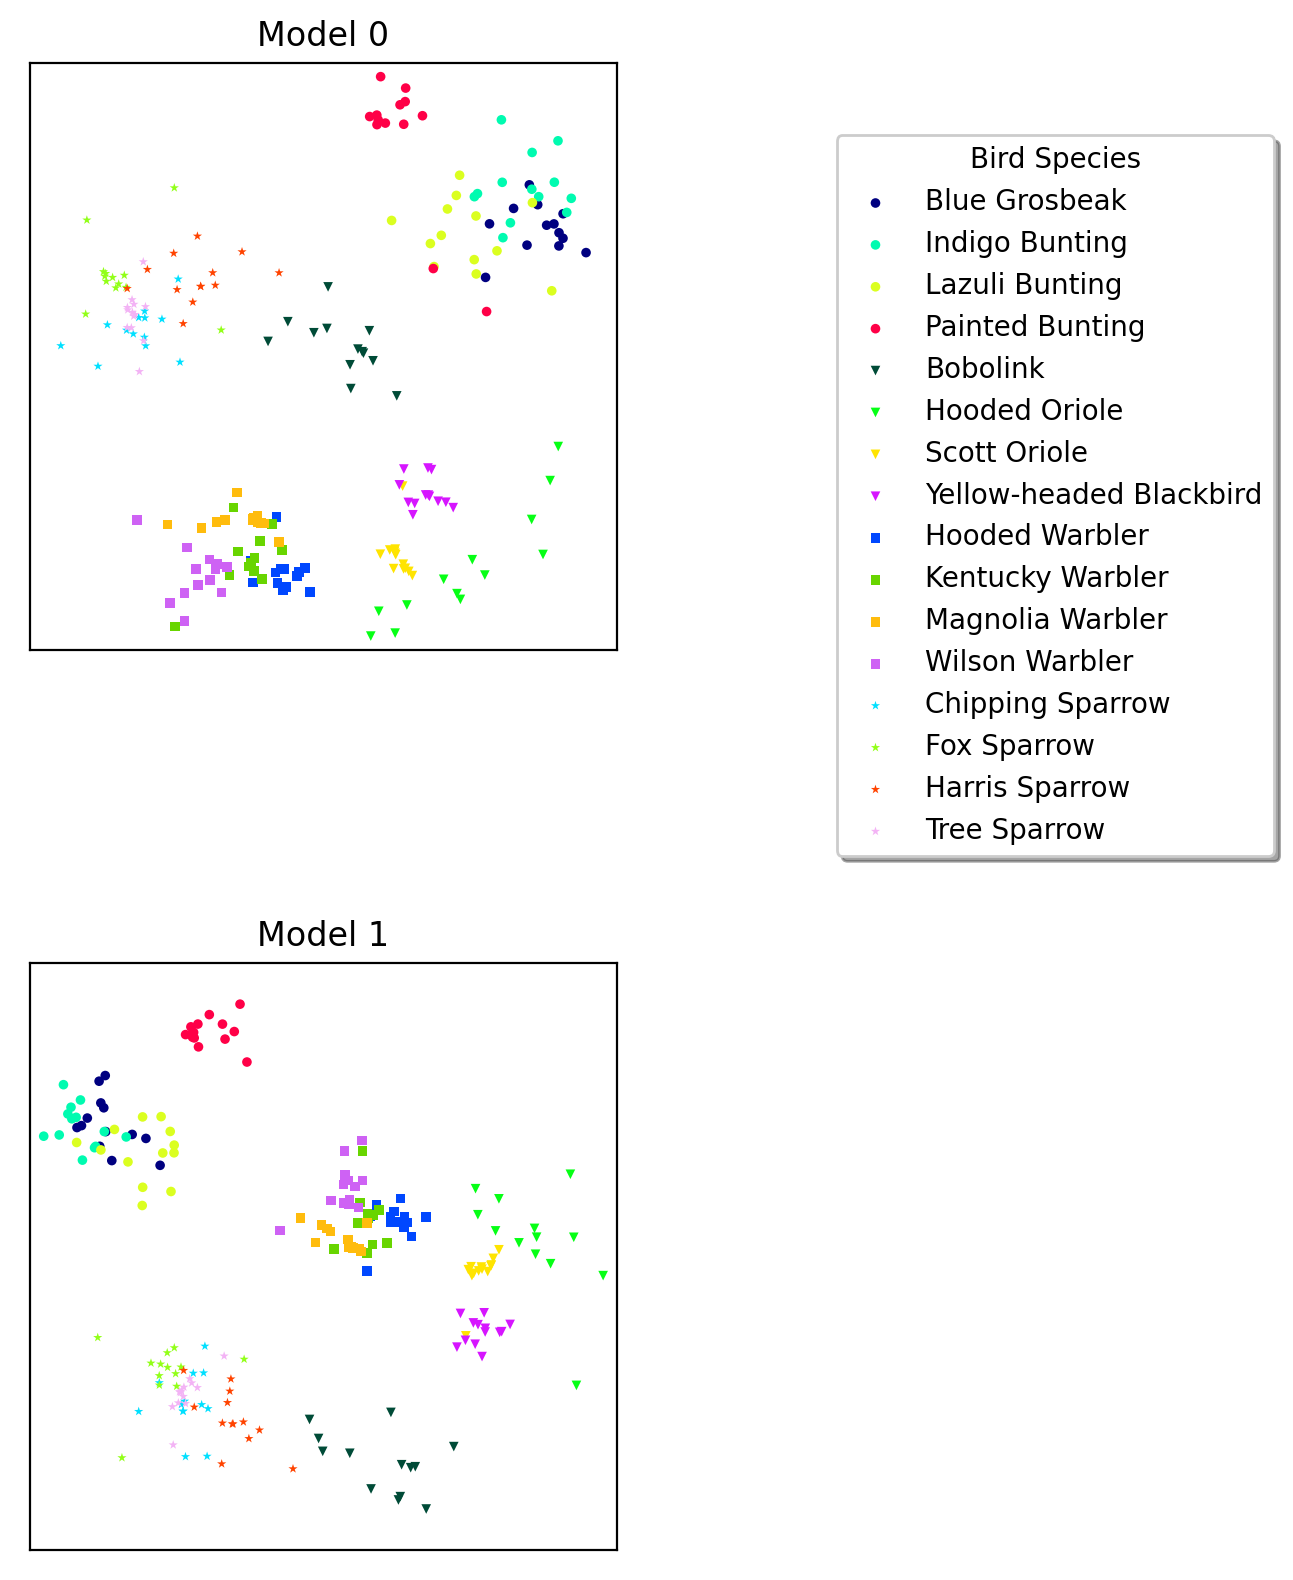

In [21]:
import matplotlib.pyplot as plt

def plot_embedding(ax, model, catalog, class_styling):
    """Plot entire embedding.
    
    Arguments:
        ax: A Matplotlib axes object.
        model: A PsiZ model.
        catalog: A corresponding PsiZ catalog.
        class_styling: A dictionary of style information for each
            class.

    """
    # Hardcoded values.
    s = 12  # Size of plot markers.

    class_id_arr = catalog.stimuli.class_id.values
    unique_class_ids = np.unique(class_id_arr)
    n_class = len(unique_class_ids)

    # Grab embedding coordinates.
    loc = model.stimuli.embeddings.numpy()
    if model.stimuli.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]

    # Center coordinates for prettier plotting.
    loc = loc - np.min(loc, axis=0) - (
        np.max(loc, axis=0) - np.min(loc, axis=0)
    ) / 2


    # Determine embedding limits.
    z_max = 1.05 * np.max(np.abs(loc))
    z_limits = [-z_max, z_max]

    # Draw stimuli modes with exemplar color-coded by class membership.
    # NOTE: We plot each class separately in order to populate the
    # figure legend correctly.
    for class_id in unique_class_ids:
        bidx_class = np.equal(class_id_arr, class_id)
        class_label = catalog.class_label[class_id].replace('_',' ')
        ax.scatter(
            loc[bidx_class, 0], loc[bidx_class, 1], s=s,
            c=class_styling[class_id]['color'],
            marker=class_styling[class_id]['marker'],
            label=class_label,
            edgecolors='none',
            zorder=100,
        )

    ax.set_xlim(z_limits)
    ax.set_ylim(z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])


# Create visual of `Model 0` and `Model 1`.
fig = plt.figure(figsize=(6.5, 8), dpi=200)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, 0])
plot_embedding(ax, model_0, catalog, class_styling)
ax.set_title('Model 0')
ax.legend(bbox_to_anchor=(1.35, 0.9), shadow=True, title="Bird Species")

ax = fig.add_subplot(gs[1, 0])
plot_embedding(ax, model_1, catalog, class_styling)
ax.set_title('Model 1')

gs.tight_layout(fig)
plt.plot()

Let's focus on the visualization for `Model 0` first. We will talk about the differences between the two models after digesting the patterns of `Model 0`. Based on the visualization, embeddings of `Model 0` appear sensible. All families form clear clusters with no family overlap. Both the Buntings and Orioles have an outlier species (Painted Bunting and Bobolink respectively). Within a taxonomic family, the Warblers and Orioles exhibit crisp species sub-clusters. The Buntings and Sparrows exhibit less distinct species sub-clusters, but clearly better than random.

### Family Embedding Visualizations

To better understand these patterns, we can visualize the actual images alongside the embedding coordinates. Since 208 images in one plot is overly crowded, we will zoom-in on each family separately. Making these kind of plots look nice and neat involves a bit more work, so the plotting code is a bit more complicated than our first visualization.

```{note}
The images for the bird-16 dataset are hosted on OSF at the `psiz-datasets` repository. A zipped directory of all the birds-16 images can be obtained [here](https://osf.io/x3vuh/). The tutorial code assumes the images are located at `~/.psiz/datasets/birds-16/img/` and that the dataset directory structure has been unaltered. For example, one of the images would have the filepath `~/.psiz/datasets/birds-16/img/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg`
```

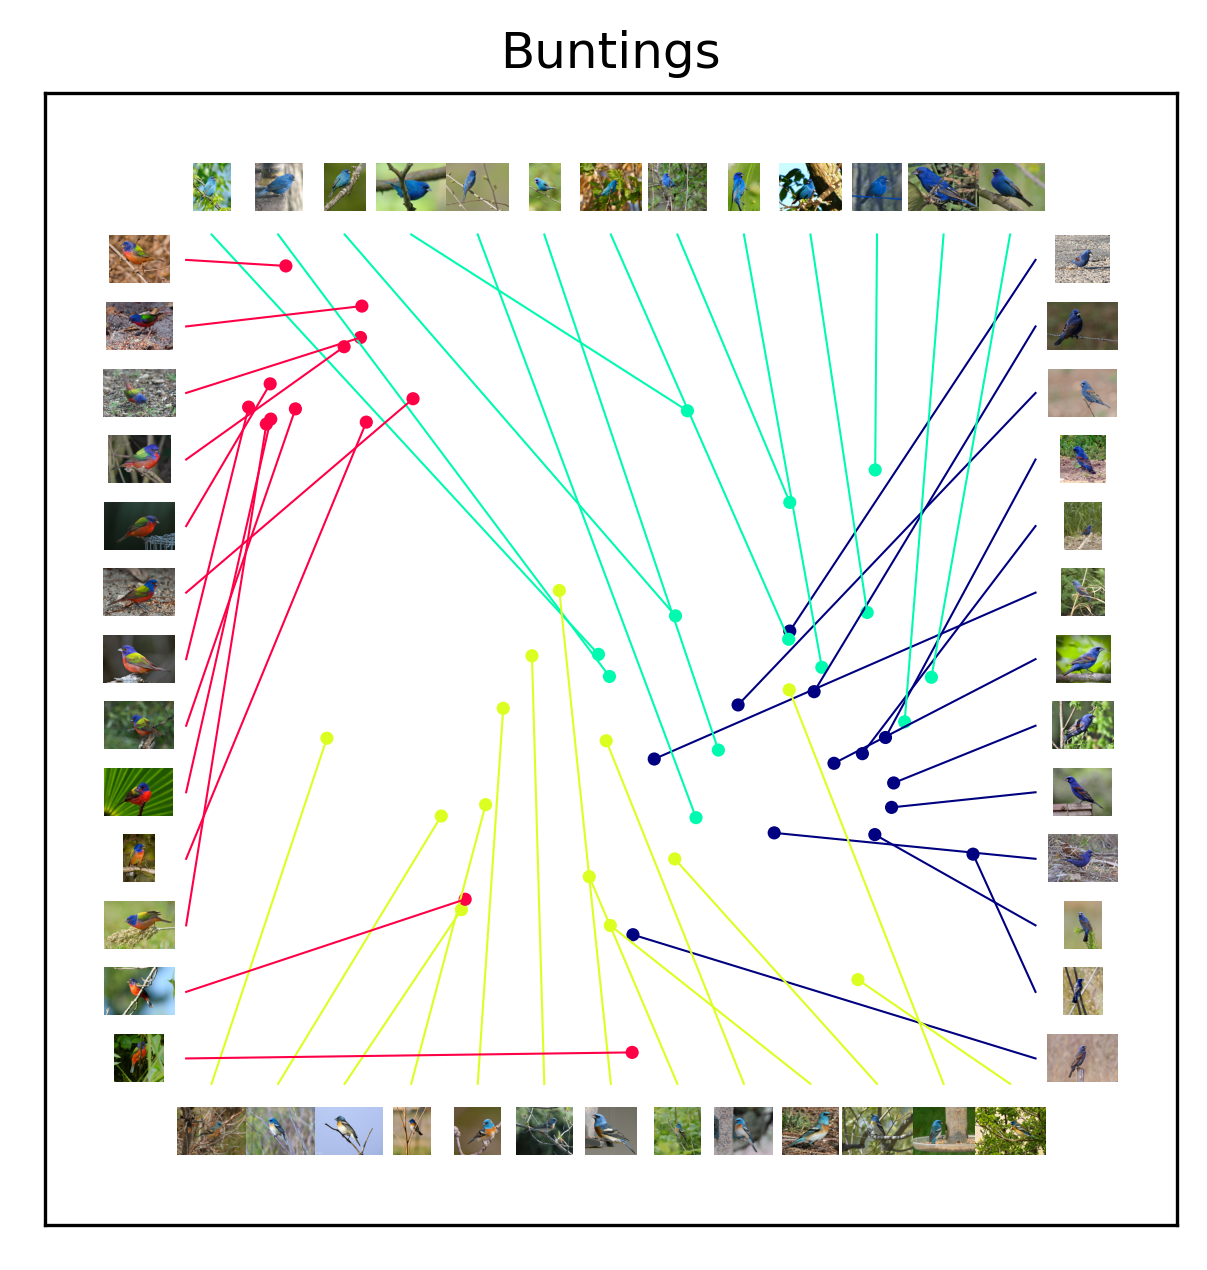

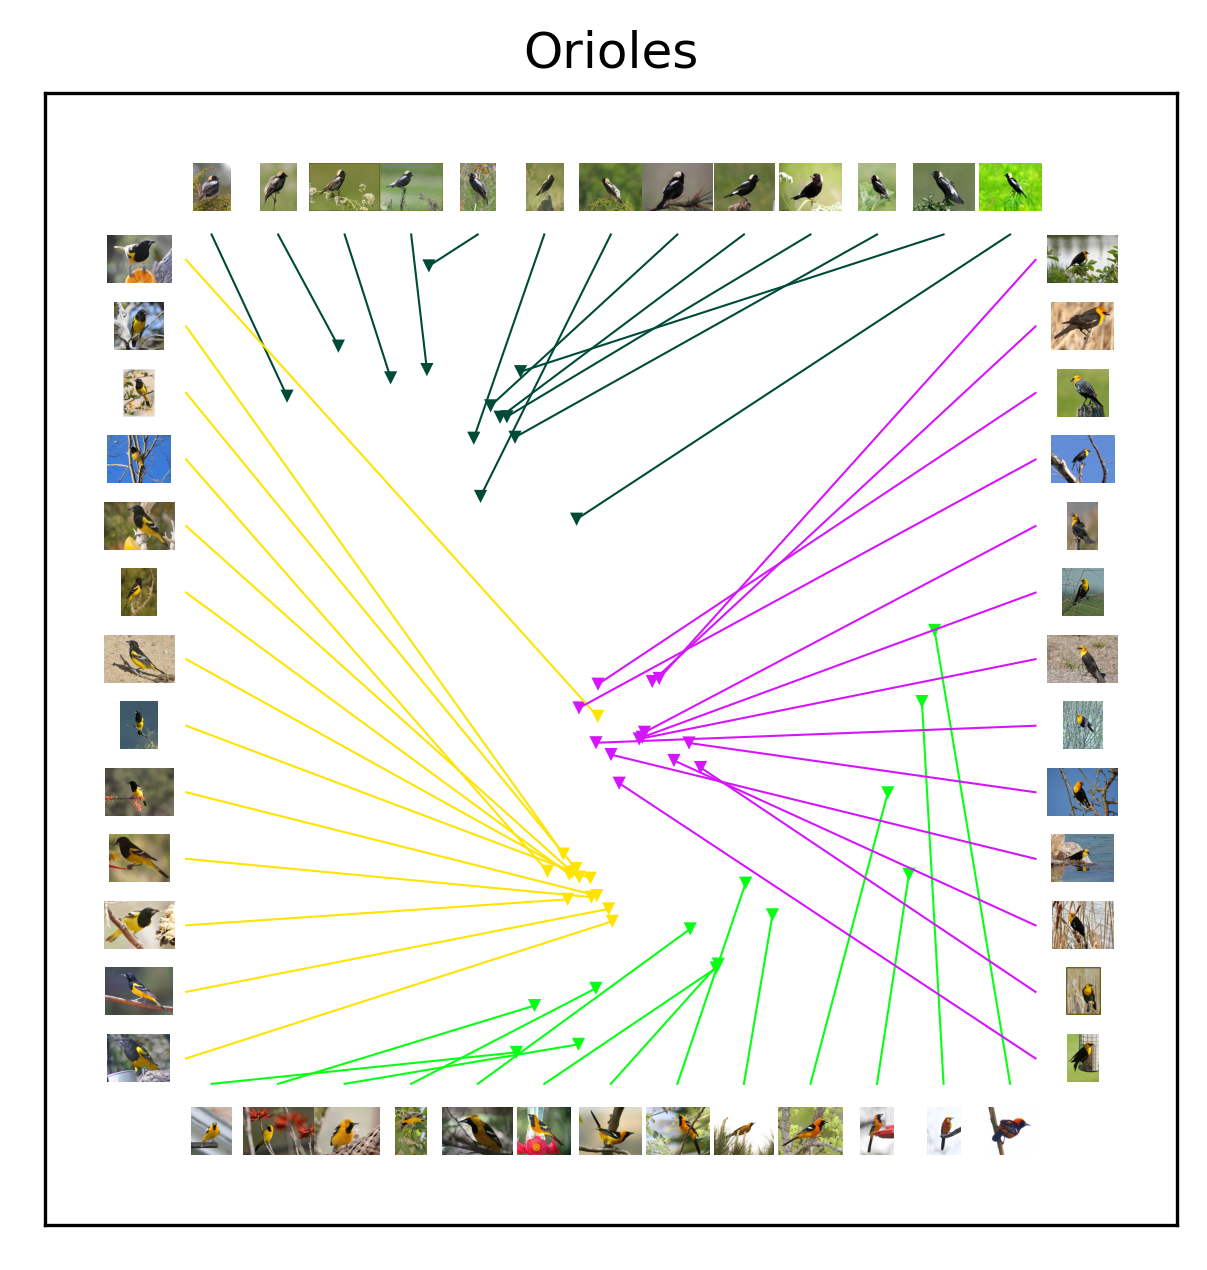

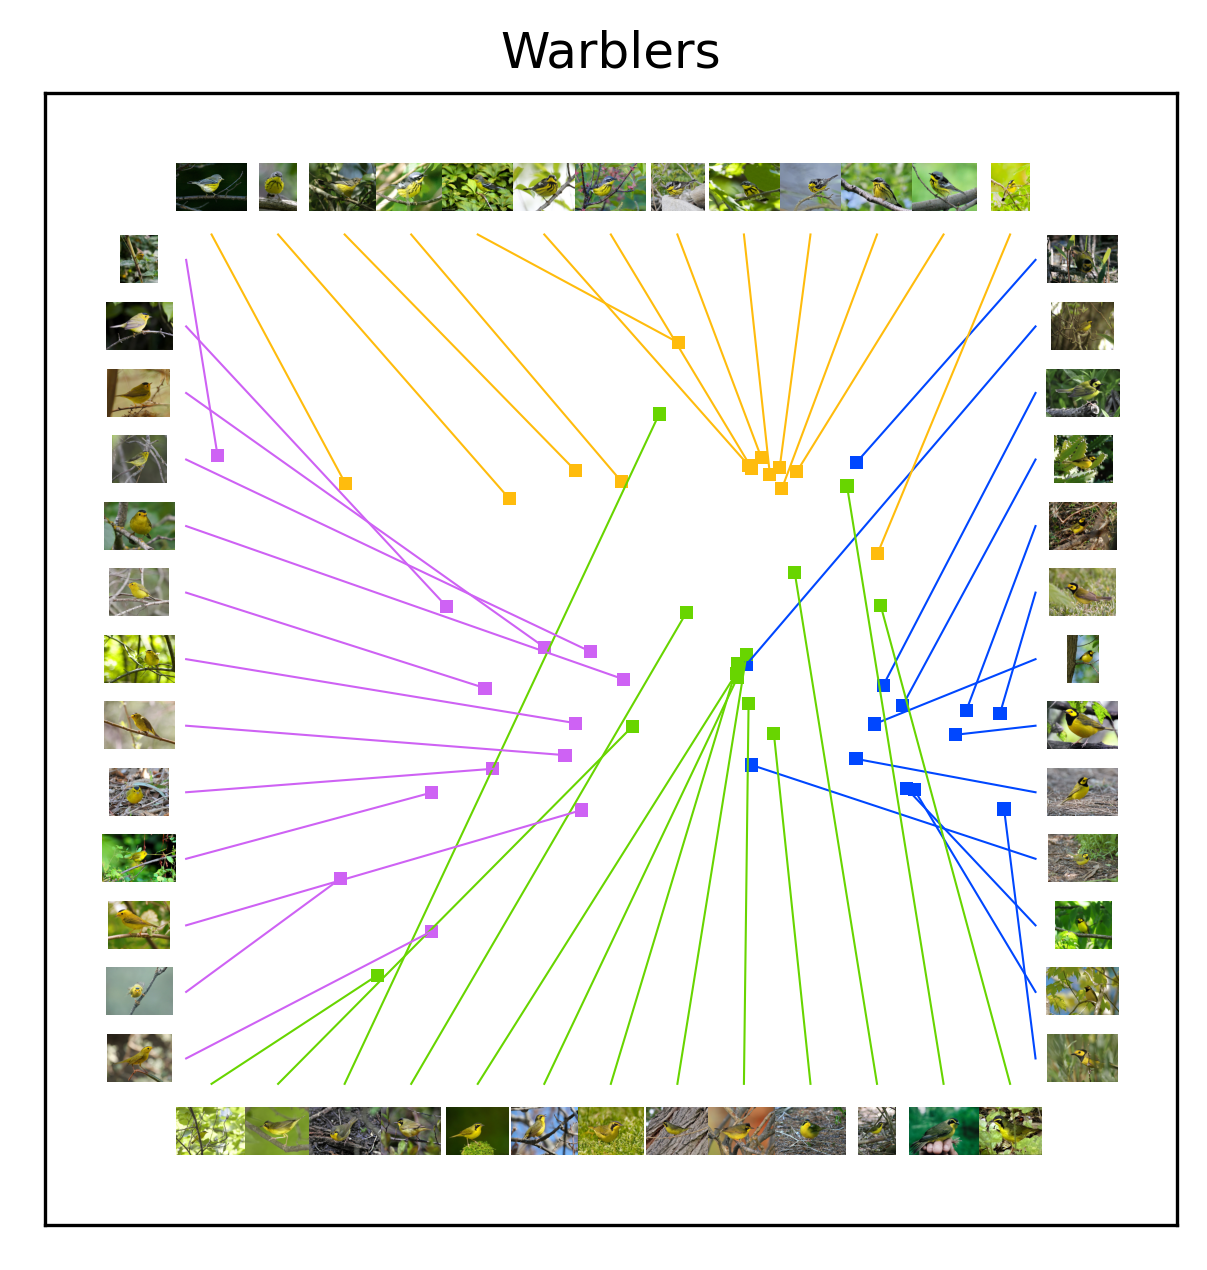

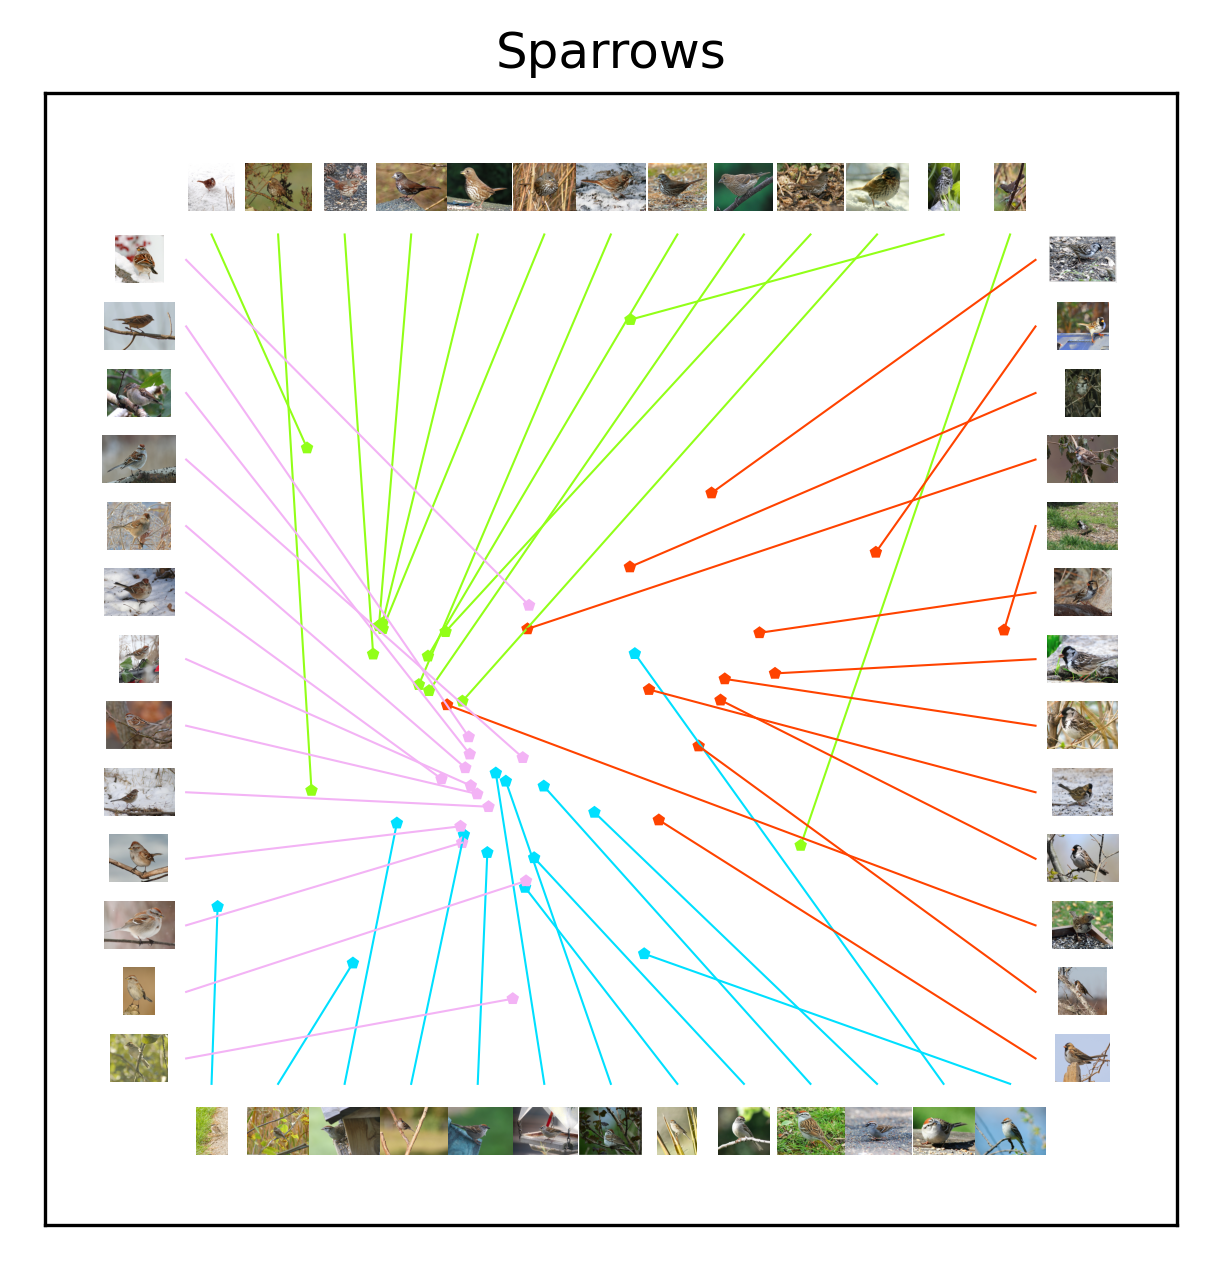

In [16]:
from pathlib import Path
from PIL import Image
import itertools


def plot_family(model, catalog, family_classes, title_str, class_styling):
    """Plot bird family embedding with images.
    
    Arguments:
        model: A PsiZ model.
        catalog: A corresponding PsiZ catalog.
        family_classes: Array-like list of class IDs included in the
            family.
        title_str: A string for the plot title.
        class_styling: A dictionary of style information for each
            class.
    """
    # Hardcoded values.
    s = 10  # Size of plot markers.
    scatter_padding = 1.2  # Padding around embedding scatter points.
    image_padding = 1.2  # Additional padding to accomodate border images.

    fig = plt.figure(figsize=(5, 5), dpi=300)
    gs = fig.add_gridspec(1, 1)

    class_id_arr = catalog.stimuli.class_id.values
    fp_arr = np.array(catalog.filepath())

    # Grab all stimuli in the family.
    bidx = np.zeros_like(class_id_arr, dtype=bool)
    for class_id in family_classes:
        bidx = np.logical_or(bidx, class_id_arr == class_id)

    # Grab embedding coordinates.
    loc = model.stimuli.embeddings.numpy()
    if model.stimuli.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]

    # Grab subset of data for family.
    loc = loc[bidx]
    fp_arr = fp_arr[bidx]
    class_id_arr = class_id_arr[bidx]

    # Center coordinates for prettier plotting.
    loc = loc - np.min(loc, axis=0) - (
        np.max(loc, axis=0) - np.min(loc, axis=0)
    ) / 2

    # Determine embedding limits of family.
    z_max = scatter_padding * np.max(np.abs(loc))
    z_limits = np.array([-z_max, z_max])

    # Draw embedding points.
    ax = fig.add_subplot(gs[0, 0])
    for class_id in family_classes:
        bidx_class = np.equal(class_id_arr, class_id)
        class_label = catalog.class_label[class_id].replace('_',' ')
        ax.scatter(
            loc[bidx_class, 0], loc[bidx_class, 1], s=s,
            c=class_styling[class_id]['color'],
            marker=class_styling[class_id]['marker'],
            label=class_label,
            edgecolors='none'
        )
    ax.set_xlim(image_padding * z_limits)
    ax.set_ylim(image_padding * z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_str)

    # Define image coordinates along border of embedding (omit corners).
    border_x = np.hstack([
        np.linspace(1, 12, 13),
        np.zeros(13),
        13 * np.ones(13),
        np.linspace(1, 12, 13),
    ])
    border_y = np.hstack([
        np.zeros(13),
        np.linspace(1, 12, 13),
        np.linspace(1, 12, 13),
        13 * np.ones(13),
    ])
    loc_outer_border = np.stack([border_x, border_y], axis=1)
    # Transform border coordinates into range of embedding coordinates.
    loc_outer_border = ((loc_outer_border / np.max(loc_outer_border)) * (2 * z_max)) - z_max
    
    border_outer_x = np.hstack([
        np.zeros(13),
        np.ones(13),
        np.ones(13),
        np.zeros(13),
    ])
    border_outer_y = np.hstack([
        np.ones(13),
        np.zeros(13),
        np.zeros(13),
        np.ones(13),
    ])
    loc_inner_border = np.stack([border_outer_x, border_outer_y], axis=1)
    loc_inner_border = loc_outer_border - (.1 * loc_inner_border * loc_outer_border)

    # Determine the best border coordinate for each stimulus.
    idx_mapped = solve_mapping(loc, loc_outer_border)
    loc_outer_border = loc_outer_border[idx_mapped]
    loc_inner_border = loc_inner_border[idx_mapped]

    # Set image size based on embedding span.
    image_size = .05 * (2 * z_max)

    # Draw images around border.
    for idx, fp_image in enumerate(fp_arr):
        # Draw line from embedding coordinate to image.
        ax.plot(
            [loc[idx, 0], loc_inner_border[idx, 0]],
            [loc[idx, 1], loc_inner_border[idx, 1]],
            c=class_styling[class_id_arr[idx]]['color'],
            linewidth=.5,
        )

        # Draw images.
        draw_image(
            fp_image, loc_outer_border[idx, 0], loc_outer_border[idx, 1],
            image_size=image_size, ax=ax, zorder=1000 + idx
        )


def solve_mapping(loc_z, loc_border):
    """Determine where images should be placed.

    Place images around border in a way that aids visual inspection.
    First assign each species to a side. Second, greedily sort stimuli
    on each side by distance.

    Arguments:
        loc_z: Coordinates of embeddings.
        loc_border: Coordinates of images along the border.

    Returns:
       idxs_mapped_best: How to rearrange the rows of `loc_border` such
        that the corresponding rows of `loc_z` are matched with the
        best image location.

    """
    # NOTE: This function assumes there are four families (one for each side)
    # and 13 stimuli per family.
    idxs_for_each_side = np.array([
        np.arange(0,13),
        np.arange(13,26),
        np.arange(26,39),
        np.arange(39,52),
    ])
    # Assign each family to one of the four sides based on distance between
    # median of embedding coordinates and median of image coordinates.
    loc_z_median = np.median(loc_z[idxs_for_each_side], axis=1)
    loc_border_median = np.median(loc_border[idxs_for_each_side], axis=1)

    def loss_func(loc_z, loc_border):
        """Euclidean distance loss function.
        
        Arguments:
            loc_z: Embedding coordinates.
            loc_border: Image coordinates.
        
        Returns:
            loss value

        """
        return np.sum(np.sqrt(np.sum((loc_z - loc_border)**2, axis=1)))

    # There are 24 possible assignments, find the best one.
    loss_best = np.inf
    perm_best = []
    for i_perm in itertools.permutations([0, 1, 2, 3]):
        loss = loss_func(loc_z_median, loc_border_median[np.array(i_perm)])
        if loss < loss_best:
            perm_best = np.array(i_perm)
            loss_best = loss
    # Expand order of sides (i.e., families) to actual exemplars.
    idxs_mapped_best = idxs_for_each_side[perm_best].flatten()
    
    # For each side, perform greedy sort. 
    for side_i in range(4):
        idxs_side_i = idxs_for_each_side[side_i]
        idxs_arranged_i = idxs_mapped_best[idxs_side_i]
        idxs_relative = arrange_images(
            loc_z[idxs_side_i], loc_border[idxs_arranged_i]
        )
        idx_arranged_i = idxs_arranged_i[idxs_relative]
        idxs_mapped_best[idxs_side_i] = idx_arranged_i
    
    return idxs_mapped_best


def arrange_images(loc_z, loc_border):
    """Arrange iamges of one side.

    Arguments:
        loc_z: Embedding coordinates.
        loc_border: Image coordinates.
    
    Returns:
        idxs_relative: An array of indices for reorder `loc_border`.

    """
    # Check if we should be sorting along x- or y-axis.
    if np.equal(loc_border[0, 0], loc_border[1, 0]):
        sort_axis = 1
    else:
        sort_axis = 0
    
    # NOTE: We call argsort twice because we want to know the indices needed
    # to sort the border array such that `loc_z` is sorted.
    idxs_relative = np.argsort(np.argsort(loc_z[:, sort_axis]))
    return idxs_relative


def draw_image(fp_image, x, y, image_size=.2, ax=None, zorder=None):
    """Draw image at coordinate.
    
    Arguments:
        fp_image: Filepath of image.
        x: x-coordinate
        y: y-coordinate
        image_size (optional): The image size expressed in terms of the
            embedding space.
        ax (optional): A Matplotlib axes object.
        zorder (optional): Integer indicating the layer order for
            plotting.

    """
    img = Image.open(fp_image)
    img_width, img_height = img.size
    aspect_ratio = img_width / img_height
    dx = aspect_ratio * image_size
    dy = image_size
    ax.imshow(
        img, extent=(x - dx/2, x + dx/2, y - dy/2, y + dy/2), zorder=zorder
    )

# Define the path to the image dataset. Update `fp_dataset` if you have stored
# the images elsewhere.
fp_dataset = Path.home() / Path('.psiz', 'datasets', 'birds-16', 'img')
catalog.common_path = fp_dataset

# Plot each bird family separately.
family_classes_0 = [2, 3, 4, 5]
plot_family(
    model_0, catalog, family_classes_0, 'Buntings', class_styling
)

family_classes_1 = [7, 8, 9, 10]
plot_family(
    model_0, catalog, family_classes_1, 'Orioles', class_styling
)

family_classes_2 = [12, 13, 14, 15]
plot_family(
    model_0, catalog, family_classes_2, 'Warblers', class_styling
)

family_classes_3 = [17, 18, 19, 20]
plot_family(
    model_0, catalog, family_classes_3, 'Sparrows', class_styling
)

After plotting the images alongside the embedding coordinates, it is clearer why some families exhibit well-defined subclusters. Starting with the Buntings and Orioles, the species all exhibit salient diagnostic features. Amongst the Buntings, the Painted Bunting exhibits a deep red belly as well as a yellow and green back that sets it apart from it's mostly blue family members. Amongst the Orioles, the Bobolink exhibits white on it's head and back, weakening the simlarity between its family members. The Sparrows are all highly similar with relatively subtle diagnostic features, making it relatively difficult to tell distinguish different species.

```{note}
Can you determine the diagnostic feature for distinguishing Tree and Chipping Sparrows? In a separate category learning experiment, most participants were unable to learn the diagnostic feature. See the end of the tutorial for the answer.
```


### What about the differences between the two models?

If we return to our first set of visualizations showing the entire embedding, you can see that the two models appear to be qualitatively different. We have already confirmed that the two models have similar losses, so what's going on? First notice that even if one applied an affine transformation (translation, scaling, rotation) to make the two solutions as similar as possible, there is still a mismatch. In `Model 0` the Bobolink coordinates are in the center of the embedding, but in `Model 1` they are not. While this seems like an huge difference from the perspective of L2 (Eulcidean) distance, it is important to remember that similarity (not distance) is the critical quantity in these models. In these models, similarity decays exponentially with increasing distance. This means that two stimuli that are moderately far apart and extremely far apart will both have a small similarity. As a consequence there are a large number of equally good solutions for embedding dissimilar items. It is the similar items that act as anchor points and constrain which solutions are viable. This flexibility means that visual inspection is fine for exploring a single embedding but it is not a great way to *compare* embeddings. To make comparisons, we need an alternative strategy.


## Similarity Analysis

Embedding coordinate visualizations yield nifty figures that are great for providing a general picture of the learned solution. But coordinates only tell part of the story. It is more important that the emeddings correctly model pairwise similarity between items. Since similarity is often a non-linear function, focusing on Euclidean distances between coordinates can be misleading. A summary of similarity can be obtained by assembling a pairwise similarity matrix $\mathbf{s}$, where the matrix element $s_{ij}$ contains the computed similarity between stimulus $i$ and stimulus $j$. "Unrolling" (i.e., rehaping) the matrix into a one dimensional array allows us to easily compare two pairwise similarity matrices.

```{note}
Depending on the similarity kernel, some elements of the similarity matrix should be omitted from the comparison. For instance, if self-similarity (i.e., diagonal ) values are uninformative, they should be excluded since they may artificially inflate the comparison. In this tutorial, self-similarity is always `1` so we exclude the diagonal elements. If the similarity kernel is symmetric (`s(z_0,z_1) = s(z_1, z_0)`), it is not necessary to compute both $s_{ij}$ and $s_{ji}. Instead one can compute just the upper (or lower) triangular portion of the similarity matrix. Since our similarity function is symmetric we will only compute the upper triangular portion.
```

A popular method of comparison is to compute the Pearson correlation between two unrolled similarity matrices. This method of comparison allows us to evaluate the extent that models exhibit *meaningful* differences. This kind of analysis has been around a long time in psychology. For example, Sheperd framed this analysis as focusing on second-order isomorphism (similarity matrix equivalency) rather than focusing on first-order isomorphism (coordinate equivalency) {cite}`Shepard_Chipman_1970`. Today, cognitive scientists often refer to this kind of analysis as representational similarity analysis (RSA) {cite}`Kriegeskorte_Mur_Bandettini_2008`.

```{note}
There are multiple strategies for comparing similarity matrices, such as canonical correlation analysis (CCA). Each approach has its strengths and weaknesses. Pearson correlation provides a simple, but intuitive strategy. In a research setting, the optimal comparison strategy will depend on the details of the project.
```

In general, computing a pairwise similarity matrix is expensive in terms of computational and storage costs. While the costs are minimal for this small stimulus set, PsiZ is designed to scale to large problems. For this reason, pairwise similarity is computed using a batch strategy. We start by creating a TF Dataset of index pairs using the PsiZ built-in function `psiz.utils.pairwise_index_dataset`. Next we compute the similarity matrix for `model_0` and `model_1`. Lastly, we compute the Pearson correlation between the two unrolled similarity matrices.


In [15]:
from scipy.stats import pearsonr


# Assemble a TF Dataset of pairwise indices that will be used to compute
# "unrolled" similarity matrices. Note that we increment by `1` since we
# are not interested in the placeholder `0` index.
ds_pairs, ds_info = psiz.utils.pairwise_index_dataset(
    np.arange(catalog.n_stimuli) + 1, elements='upper'
)

# The "unrolled" similarity matrix of `Model 0`.
simmat_0 = psiz.utils.pairwise_similarity(
    model_0.stimuli, model_0.kernel, ds_pairs
).numpy()

# The "unrolled" similarity matrix of `Model 1`.
simmat_1 = psiz.utils.pairwise_similarity(
    model_1.stimuli, model_1.kernel, ds_pairs
).numpy()

rho, _ = pearsonr(simmat_0, simmat_1)
print('Pearson rho: {0:.2f}'.format(rho))

Pearson rho: 0.95


The high Pearson correlation reveals that what initially seemed like a notable difference from the perspective of the coordinates and Euclidean distance, is only a minor difference from the perspective of pairwise similarity. The high correlation value also shows that the embedding solution is stable, suggesting that a sufficient amount of data has been collected.

```{note}
A simple heuristic for deciding if an embedding is stable is a Pearson correlation of 0.95 or greater. Depending on your research goals, you may need to use a lower or higher threshold. Aiming for a correlation of 1.00 is typically not practical since there are diminishing returns to data collection. If a high Pearson correlation is necessary, you should strongly consider active learning in order to make the most of your data collection budget.
```

# Summary

The Beginner tutorial introduced the PsiZ data format, how to construct a basic embedding model, how to visualize a learned embedding, and perform a basic RSA analysis. The beginner tutorial employed a number of simplifications to keep the focus on the general organization of PsiZ and avoid getting bogged down in technical details. If you would like to explore a more sophisticated model, variational inference (VI) models are a great place to start. Variational inference enables models to learn a distribution for each free parameter, allowing researchers to obtain uncertainty estimates for the embedding coordinates---moving beyond point estimates. Check out any of the variational inference [examples on PsiZ's GitHub](https://github.com/roads/psiz/tree/main/examples) to learn more.

## Exercises

1. Re-train the models, but fit a 3D embedding. Do the 2D or 3D embeddings have a better test loss? What does this mean from the perspective of selecting a model with the best generalization performance?
2. Re-train the models, but only use 10% of the data. Using these new models, conduct an RSA analysis. What does the RSA analysis suggest? Is 10% of the data sufficeint to achieve a stable embedding?
3. Repeat the tutorial using a new dataset that contains ranked similarity judgments for rock stimuli. Load the new dataset using `(obs, catalog) = psiz.datasets.load_dataset('rocks_Nosofsky_etal_2016', verbose=1)`. Modify the model construction code to fit this new dataset and create a new way to display the embedding points and rock images (you could start by simply plotting the images at the embedding coordiantes). The rocks dataset uses stimuli from {cite:t}`Nosofsky_etal_2018_rocks`. The stimuli can be downloaded from the original authors' [OSF page](https://osf.io/w64fv/) (images are stored in the "Rocks Library" directory).

```{bibliography}
:style: plain
```

```{note}
In the birds-16 image dataset, the color of the eye stripe distinguishes a Chipping and Tree Sparrow (brown versus black).
```